<div>
<img src="images/haiqu01.png" style="border-radius: 16px;"/>
</div>

# Haiqu Challenge for PushQuantum Hackathon 2025

Welcome to the Haiqu Challenge for the PushQuantum Hackathon 2025! This notebook contains all the information you need to participate in this exciting event.

--- 

# Partial Fault Tolerance Challenge

Quantum circuits are inherently noisy: every gate, qubit idle time, and measurement introduces errors that accumulate and degrade computational accuracy. Full quantum error correction (QEC) can suppress these errors, but at the cost of significant qubit overhead and circuit complexity - far beyond what today’s hardware can support.

**Early Fault-Tolerant Quantum Computing (EFTQC)** is a more realistic setting with imperfect error correction and finite logical error rates being achievable already today (see the demostrations by [Google](https://www.nature.com/articles/s41586-024-08449-y), [QuEra](https://www.nature.com/articles/s41586-023-06927-3), [Quantinuum](https://arxiv.org/abs/2509.25326) etc.). In the paradigm of this challenge, we aim to explore the ansatz of partial QEC. Instead of protecting *every* qubit and *every* operation, partial QEC selectively applies error correction where it matters most. In this challenge, you will explore a setting, in which *only one gate at a time* in the circuit may be executed in a fault-tolerant (encoded) manner. For inspiration and motivation, we recommend exploring the following paper by the Los Alamos National Laboratory team: [Koukoulekidis et al. (2023)](https://arxiv.org/abs/2306.15531).

## Challenge task
Your task is to write a **transformation pass** that takes an input `QuantumCircuit` and outputs a modified version where certain gates are replaced by special **fault-tolerant placeholders**. These placeholders are treated differently by the noise model, giving you the ability to reduce the overall error accumulation — but under strict constraints.

You will be provided with:

- A dataset of circuits to develop and tune your strategy,
- A noise model that distinguishes between normal and fault-tolerant gates,
- Tools to verify that you follow the challenge rules,
- A grading function to measure how much your transformation improves fidelity.

Your goal is simple: **maximize the average fidelity** of the circuits under noise, by carefully choosing *when* and *where* to apply fault-tolerant protection.

Let’s begin!

---


## Environment Setup & Imports

We will be using the latest version of Qiskit for this challenge. **If you have an older version installed, note that backward compatibility is not guaranteed**.

In [1]:
!pip install qiskit==2.2.3 qiskit-aer==0.17.2
!pip install numpy matplotlib

     ---------------------------------------- 7.8/7.8 MB 10.6 MB/s eta 0:00:00
     ---------------------------------------- 9.6/9.6 MB 13.6 MB/s eta 0:00:00
     ---------------------------------------- 2.1/2.1 MB 14.5 MB/s eta 0:00:00
     -------------------------------------- 119.7/119.7 kB 6.8 MB/s eta 0:00:00
     ---------------------------------------- 54.4/54.4 kB ? eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import qiskit
import qiskit_aer

# Version check
print("Qiskit version:", qiskit.__version__)
print("Qiskit Aer version:", qiskit_aer.__version__)

REQUIRED_QISKIT = "2.2.3"
REQUIRED_AER = "0.17.2"

if qiskit.__version__ != REQUIRED_QISKIT:
    print(f"⚠️ Warning: Expected Qiskit {REQUIRED_QISKIT}, "
          f"but found {qiskit.__version__}.")
if qiskit_aer.__version__ != REQUIRED_AER:
    print(f"⚠️ Warning: Expected Qiskit Aer {REQUIRED_AER}, "
          f"but found {qiskit_aer.__version__}.")

Qiskit version: 2.2.3
Qiskit Aer version: 0.17.2


In [2]:
import numpy as np

from qiskit import QuantumCircuit

# Set a reproducible random seed
np.random.seed(42)
print("Environment initialized.")

Environment initialized.


--- 

## Part 1 — Fault-Tolerant Placeholders for IBM Native Gates

In this challenge we work with a **fixed native gate set**, similar to what is used on IBM hardware:

- Single-qubit gates: `X`, `SX`, `RZ`, `RX`
- Two-qubit gates: `RZZ`, `CZ`

In Qiskit, these appear as gate names:

- `"x"`, `"sx"`, `"rz"`, `"rx"`, `"rzz"`, `"cz"`

We do **not** ask you to design fault-tolerant implementations of these gates.  
Instead, we provide a **hardcoded library of placeholder equivalents** that represent
“fault-tolerant versions” of these same gates. Each native gate can be replaced by a
placeholder with a `_ft` suffix, for example:

- `x`  → `x_ft`
- `sx` → `sx_ft`
- `rz` → `rz_ft`
- `rx` → `rx_ft`
- `rzz` → `rzz_ft`
- `cz` → `cz_ft`

These `_ft` gates:

- Act on the **same qubits** as the original,
- Carry the **same parameters** (e.g., rotation angles),
- Are treated differently by the **noise model** later on (typically less or no noise).

Your job in this challenge is *only* to decide **where in a circuit** to swap a native gate
for its `_ft` placeholder (under the “one FT gate at a time” constraint) — not to modify
this library of equivalences.



In [3]:
# This helper module is provided by the organizers.
# It contains:
#   - ALLOWED_BASE_GATES: the native gate set you are allowed to tag as FT
#       {"x", "sx", "rz", "rx", "rzz", "cz"}
#   - to_ft_instruction(inst): returns the corresponding *_ft Instruction,
#       preserving parameters and qubit structure.
try:
    from haiqu_utils import (
        ALLOWED_BASE_GATES,
        to_ft_instruction,
    )
except ImportError as exc:
    raise ImportError(
        "Could not import 'haiqu_utils'. Make sure the helper package or utils.py "
        "is available in your environment."
    ) from exc

print("Allowed base gates:", ALLOWED_BASE_GATES)

Allowed base gates: {'cz', 'rzz', 'rx', 'sx', 'x', 'rz'}


Below we provide a simple example of how to perform such a transformation using Qiskit.

In [4]:
from qiskit.converters import circuit_to_dag, dag_to_circuit

def reference_transform(circ: QuantumCircuit) -> QuantumCircuit:
    """
    Baseline transformation pass that:

      - Preserves the circuit structure (same ops, same order, same wires),
      - Selects at most one gate per DAG layer to mark as FT,
      - Replaces only those gates by FT-labelled versions via to_ft_instruction.

    Implementation strategy:
      1. Build DAG from the original circuit.
      2. Build a mapping from node_id -> original DAG node.
      3. Iterate over DAG layers and, per layer, pick at most one candidate node
         whose op.name is in ALLOWED_BASE_GATES.
      4. For each chosen node_id, look up the original node and replace node.op
         with the FT version.
      5. Convert the modified DAG back to a QuantumCircuit.

    This is a simple baseline; participants should implement a better strategy
    in their own transform_circuit, but it must obey the same rules.
    """
    dag = circuit_to_dag(circ)
    new_dag = dag.copy_empty_like()

    # 1) Decide which nodes to mark as FT: at most one per layer
    for layer in dag.layers():
        layer_dag = layer["graph"]
        for node in layer_dag.op_nodes():
            if getattr(node.op, "name") in ALLOWED_BASE_GATES:
                layer_dag.substitute_node(
                    node,
                    to_ft_instruction(node.op)
                )
                break  # Only one per layer
        new_dag.compose(layer_dag, inplace=True)
   
    # 3) Convert back to a QuantumCircuit
    transformed = dag_to_circuit(new_dag)
    transformed.name = circ.name + "_ft"
    return transformed

Starting from a simple demo circuit:

In [7]:
!pip install pylatexenc

     -------------------------------------- 162.6/162.6 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136849 sha256=890689d9d35beb7ad4db0461e0a70adf293a3fe4744b09a407a0ae31a6d5e2a1
  Stored in directory: c:\users\cesar\appdata\local\pip\cache\wheels\f9\3a\c5\e0053bc7e7caf136026ff881868458df8215b51df46b402801
Successfully built pylatexenc



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Original circuit:


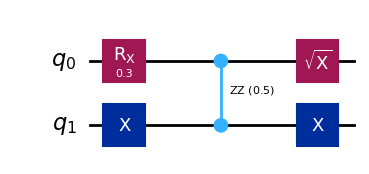

In [5]:
demo = QuantumCircuit(2, name="demo")
demo.rx(0.3, 0)
demo.x(1)
demo.rzz(0.5, 0, 1)
demo.sx(0)
demo.x(1)

print("Original circuit:")
demo.draw("mpl", fold=-1)

We apply our `reference_transform` function that replaces each gate with its FT placeholder:


Transformed circuit with FT placeholders (reference_transform):


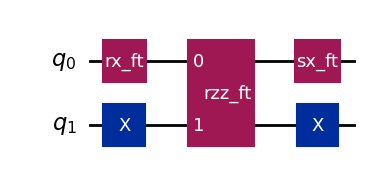

In [7]:
demo_ft = reference_transform(demo)
print("\nTransformed circuit with FT placeholders (reference_transform):")
demo_ft.draw("mpl", fold=-1)

As you can see, every non-simultaneous gate in the original circuit has been replaced by its corresponding fault-tolerant placeholder.

---

## Part 2 — Noise Model

We now introduce the **noise model** used in this challenge.

- Native gates (`x`, `sx`, `rz`, `rx`, `rzz`, `cz`) are noisy:
  - 1-qubit gates get depolarizing noise with probability `p_1q`,
  - 2-qubit gates get depolarizing noise with probability `p_2q`.

- Fault-tolerant gates (`x_ft`, `sx_ft`, `rz_ft`, `rx_ft`, `rzz_ft`, `cz_ft`) are treated
  differently:
  - By default, they are **ideal** (no noise),
  - Optionally, we can set a small `ft_scale` so they have reduced noise compared to native gates.

You should **not** modify the noise model during the challenge.
Your job is to exploit it by deciding **where** to place the `_ft` gates.

Now let's configure the noise model and simulator:

In [8]:
from qiskit_aer import AerSimulator

try:
    from haiqu_utils import build_noise_model
except ImportError as exc:
    raise ImportError(
        "Could not import 'haiqu_utils'. Make sure the helper package or utils.py "
        "is available in your environment."
    ) from exc


p_1q = 1e-2   # depolarizing error for 1-qubit native gates
p_2q = 5e-2   # depolarizing error for 2-qubit native gates
ft_scale = 0.0 # ideal FT gates

noise_model = build_noise_model(p_1q=p_1q, p_2q=p_2q, ft_scale=ft_scale)

ideal_sim = AerSimulator()
noisy_sim = AerSimulator(noise_model=noise_model)

print("Noise model configured with:")
print(f"  p_1q      = {p_1q}")
print(f"  p_2q      = {p_2q}")
print(f"  ft_scale  = {ft_scale}")

Noise model configured with:
  p_1q      = 0.01
  p_2q      = 0.05
  ft_scale  = 0.0


To see the effect of our pass, let's use a slightly larger test circuit using Qiskit's `random_circuit` function. We need to transpile to our gateset before running our transformation pass.


Original test circuit:


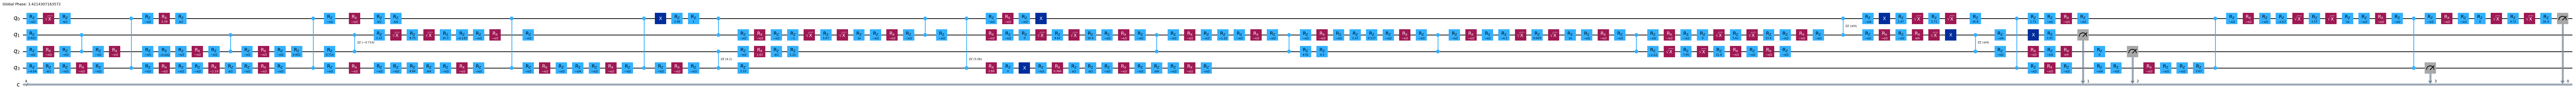

In [9]:
from qiskit.circuit.random import random_circuit
from qiskit.compiler import transpile

test = random_circuit(num_qubits=4, depth=10, max_operands=2, seed=42, measure=True)
test = transpile(test, noisy_sim, optimization_level=0)

print("\nOriginal test circuit:")
test.draw(output="mpl", fold=-1)

Let's apply our FT transformation to this test circuit:

Transformed circuit with FT placeholders:


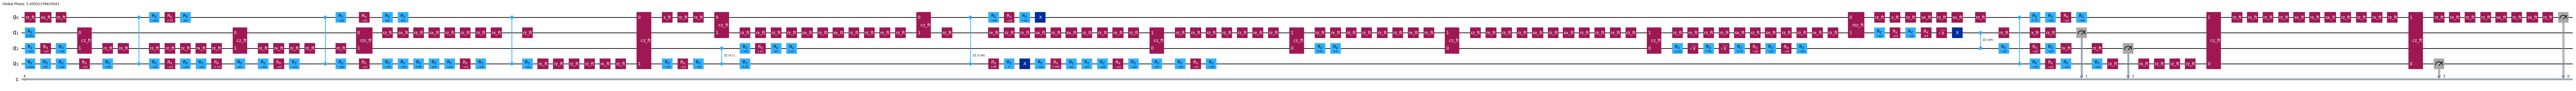

In [10]:
test_ft = reference_transform(test)

print("Transformed circuit with FT placeholders:")
test_ft.draw(output="mpl", fold=-1)

Finally, we can simulate both the original and transformed circuits under the noise model and compare their fidelities. But first, let's verify that the transformed circuit produces the same ideal results as the original.

Hellinger fidelity between ideal results: 0.9990114448239084


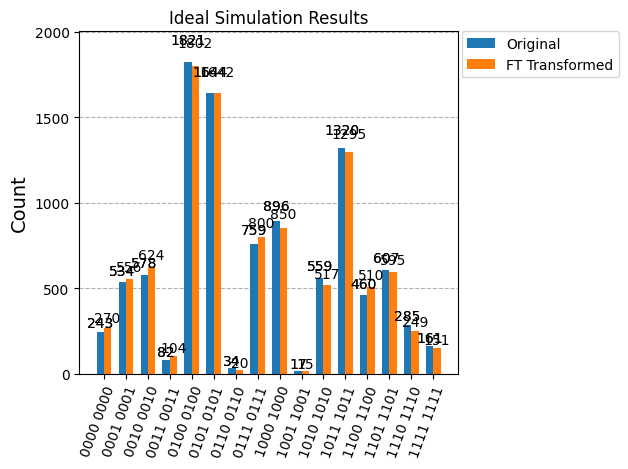

In [11]:
from qiskit.quantum_info import hellinger_fidelity
from qiskit.visualization import plot_histogram

test.measure_all()
test_transpiled = transpile(test, ideal_sim, optimization_level=0)
test_ideal_result = ideal_sim.run(test_transpiled, shots=10000).result().get_counts()

test_ft.measure_all()
test_ft_transpiled = transpile(test_ft, ideal_sim, optimization_level=0)
test_ft_ideal_result = ideal_sim.run(test_ft_transpiled, shots=10000).result().get_counts()

print("Hellinger fidelity between ideal results:",
      hellinger_fidelity(test_ideal_result, test_ft_ideal_result))

plot_histogram([test_ideal_result, test_ft_ideal_result],
               legend=["Original", "FT Transformed"],
               title="Ideal Simulation Results")

Excellent! Now we can proceed to simulate both circuits under the noise model and evaluate the fidelity improvement achieved by our transformation.

In [12]:
test_transpiled_noisy = transpile(test, noisy_sim, optimization_level=0)
test_noisy_result = noisy_sim.run(test_transpiled_noisy, shots=10000).result().get_counts()

test_ft_transpiled_noisy = transpile(test_ft, noisy_sim, optimization_level=0)
test_ft_noisy_result = noisy_sim.run(test_ft_transpiled_noisy, shots=10000).result().get_counts()

print(f"Hellinger fidelity for the initial circuit: ",
      hellinger_fidelity(test_noisy_result, test_ideal_result))
print(f"Hellinger fidelity for the transformed circuit: ",
      hellinger_fidelity(test_ft_noisy_result, test_ft_ideal_result))

Hellinger fidelity for the initial circuit:  0.8527076434626818
Hellinger fidelity for the transformed circuit:  0.9451476431990333


Notice how there is a significant improvement in Hellinger fidelity when using the fault-tolerant transformation. Now it is up to you to design a strategy that maximizes this improvement across a variety of circuits! 

---

## Part 3 — Verifying Your Transformation

Before we grade anything, we need to check that your
`transform_circuit` obeys the **challenge rules**.

The verifier checks:

1. **Logical circuit equivalence (up to FT tags)**  
   - State fidelity between original and transformed circuit is ≥ 0.999

3. **FT constraint per layer**  
   - In every parallel time slice (DAG layer), there is **at most one** FT gate.

If any of these conditions are violated, the verifier reports a list of
error messages. The grader will treat such submissions as invalid.


In [13]:
try: 
    from haiqu_utils import verify_transformation
except ImportError as exc:
    raise ImportError(
        "Could not import 'haiqu_utils'. Make sure the helper package or utils.py "
        "is available in your environment."
    ) from exc

# Run the verifier
report = verify_transformation(test, test_ft)

if report["ok"]:
    print("✅ Verification passed: transformation obeys the rules.")
else:
    print("❌ Verification failed. Issues found:")
    for err in report["errors"]:
        print("  -", err)

✅ Verification passed: transformation obeys the rules.


--- 

## Part 4 — The Grader: How Your Score Is Computed

To evaluate your strategy for partial fault tolerance, we use a **fidelity-improvement metric**.  
This measures how much your transformation helps the circuit withstand noise.

For each circuit in the evaluation set, the grader performs the following steps:

1. **Ideal reference:**  
   Compute the ideal output probability distribution of the *original* circuit.

2. **Baseline under noise:**  
   Simulate the noisy execution of the original circuit, producing a baseline fidelity  
($F_{\text{plain}}$) between the noisy and ideal distributions.

3. **Your transformed circuit:**  
   Apply your `transform_circuit` function, verify that it obeys the challenge rules  
   (logical correctness + at most one FT gate per layer),  
   and simulate it under the same noise model to obtain $F_{\text{FT}}$.

4. **Improvement:**  
   Your score for that circuit is the *gain in fidelity*:
   $$
   \Delta F = F_{\text{FT}} - F_{\text{plain}}.
   $$

The final score is the **average improvement** across all evaluation circuits.  
A higher score means your strategy more effectively deploys limited fault tolerance.

> **Note:** If the transformed circuit violates the challenge constraints  
> (e.g., more than one FT gate per layer, or incorrect final state),  
> the submission is marked invalid — but the grader still reports diagnostic details
> to help you debug your approach.


In [14]:
try: 
    from haiqu_utils import grader
except ImportError as exc:
    raise ImportError(
        "Could not import 'haiqu_utils'. Make sure the helper package or utils.py "
        "is available in your environment."
    ) from exc

random_qubits = np.random.randint(3, 7, size=5)
random_depths = np.random.randint(10, 21, size=5)
random_circuits = [
    transpile(
        random_circuit(num_qubits=nq, depth=nd, max_operands=2, seed=seed, measure=True),
        noisy_sim,
        optimization_level=0,
    )
    for seed, nq, nd in zip(range(5), random_qubits, random_depths)
]

print("Running grader...")

grade = grader(
    transform_circuit_fn=reference_transform,
    circuits=random_circuits,
    noise_model=noise_model,
    shots=200_000,   # reduce for demo speed
)

print("Valid submission?      :", grade["ok"])
print("Average improvement    :", grade["average_improvement"])
print("Per-circuit improvement:", grade["improvements"])
print("Plain fidelities       :", grade["fidelities_plain"])
print("FT fidelities          :", grade["fidelities_ft"])

if not grade["ok"]:
    print("\nErrors:")
    for err in grade["errors"]:
        print("  -", err)


Running grader...
Valid submission?      : True
Average improvement    : 0.06259638339946152
Per-circuit improvement: [0.08719261019162161, 0.10451781713967623, 0.031047595074601197, 0.031667847530100324, 0.058556047061308236]
Plain fidelities       : [0.7120776937876718, 0.7318920699724035, 0.713318904197291, 0.7950749548812616, 0.8180180316225009]
FT fidelities          : [0.7992703039792934, 0.8364098871120798, 0.7443664992718922, 0.8267428024113619, 0.8765740786838091]


--- 

# Part 5 - Let the fun begin!

Now it's your turn to design a strategy for partial fault tolerance! Remember, your deliverable is a function `transform_circuit(circ: QuantumCircuit) -> QuantumCircuit` that takes an input circuit and returns a modified version with selected gates replaced by their fault-tolerant placeholders.

Your final points will consist on 50% of the improvement in fidelity and on 50% of the jury score of the your approach and explanation. Good luck and have fun!
